# Etki Karışımı Örneği: Gözlemlenen Verilerden Nedensel Etkileri Bulma

Diyelim ki size tedavi ve sonuçla ilgili bazı veriler verildi. Tedavinin sonuca neden olup olmadığını veya korelasyonun tamamen başka bir ortak nedenden kaynaklanıp kaynaklanmadığını belirleyebilir misiniz?

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)

Veri kümesinin oluşturulması. İki modelden birinden üretilir: 
* Model 1: Tedavi sonuca neden olur. 
* Model 2: Tedavi sonuca neden olmaz. 

Gözlemlenen tüm korelasyon ortak bir nedene bağlıdır.

In [8]:
rvar = 1 if np.random.uniform() >0.5 else 0
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar,
                                      num_common_causes=1,
                                      sd_error=0.2)
df = data_dict['df']
print(df[["Treatment", "Outcome", "w0"]].head())

   Treatment    Outcome        w0
0   2.480615   5.006662 -3.430638
1   8.454780  17.240757  2.648280
2   4.183548   7.564984 -2.042381
3  10.341196  19.810419  4.133462
4   7.710755  15.967114  1.985158


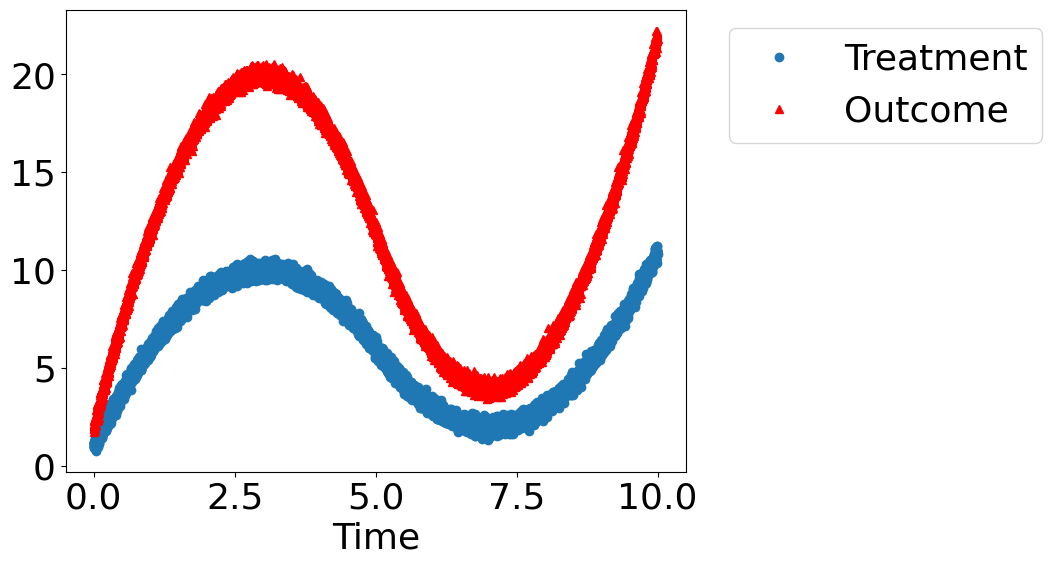

In [9]:
dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], 
                                     df[data_dict["outcome_name"]],
                                     df[data_dict["time_val"]])

# DoWhy'ı kullanarak şu gizemi çözüyoruz: Tedavi Sonuç Verir mi?

### ADIM 1: Sorunu nedensel bir grafik olarak modelleme

In [10]:
help(model.view_model)

Help on method view_model in module dowhy.causal_model:

view_model(layout=None, size=(8, 6), file_name='causal_model') method of dowhy.causal_model.CausalModel instance
    View the causal DAG.
    
    :param layout: string specifying the layout of the graph.
    :param size: tuple (x, y) specifying the width and height of the figure in inches.
    :param file_name: string specifying the file name for the saved causal graph png.
    
    :returns: a visualization of the graph



In [14]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

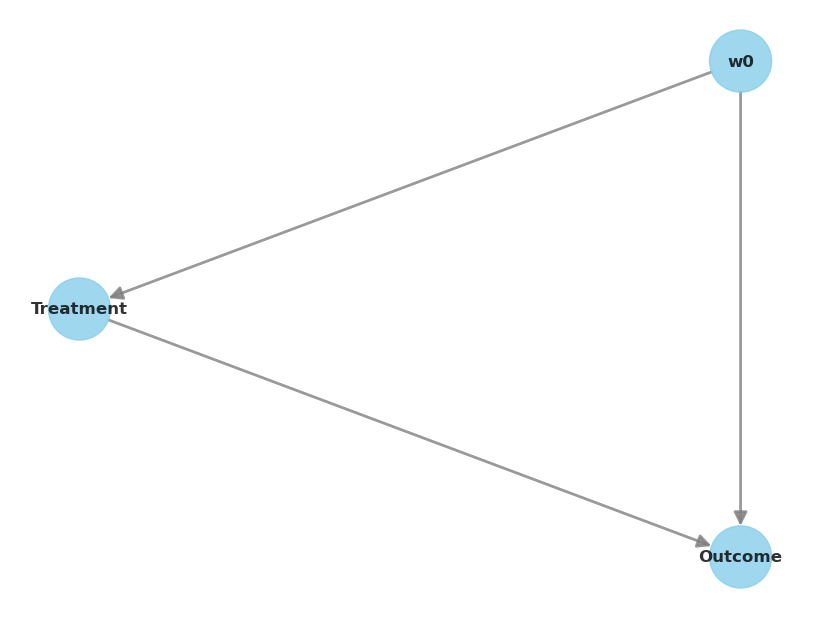

In [15]:
model= CausalModel(
        data=df,
        treatment=data_dict["treatment_name"],
        outcome=data_dict["outcome_name"],
        common_causes=data_dict["common_causes_names"],
        instruments=data_dict["instrument_names"])
model.view_model(layout="dot")

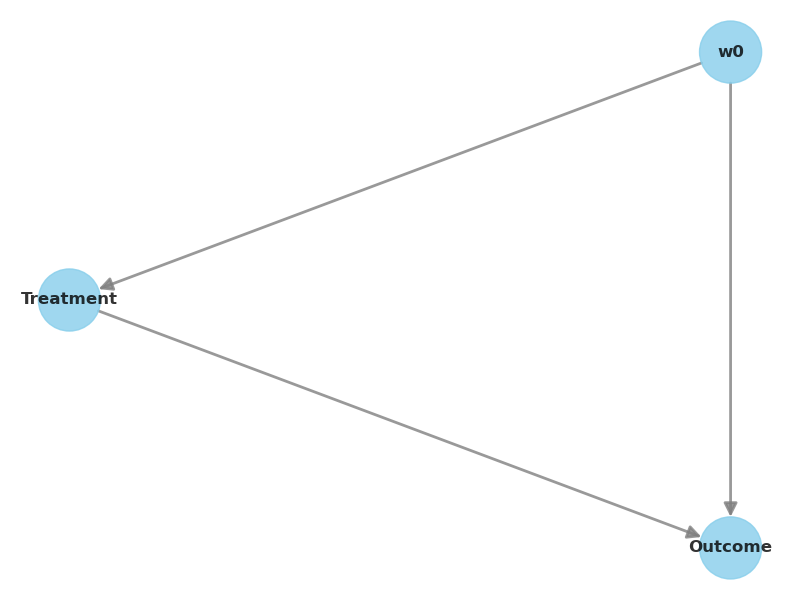

In [16]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

### ADIM 2: Nedensel Etkinin Formel Nedensel Grafik Özellikleri Kullanılarak Tanımlanması

In [17]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[Outcome|w0])
d[Treatment]               
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,U) = P(Outcome|Treatment,w0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### ADIM 3: Nedensel Etkiyi Tahmin Etme

Causal Estimate is -0.0016735408416916897


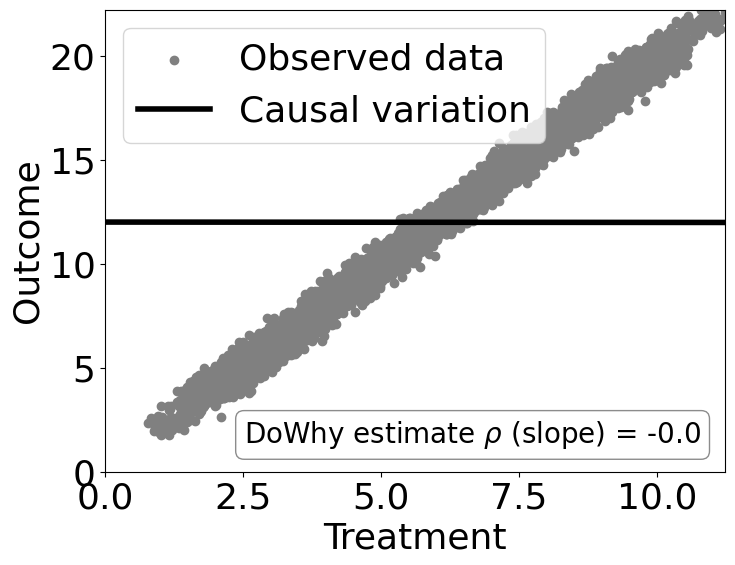

In [18]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("Causal Estimate is " + str(estimate.value))

# plot slope of line between treamtent and outcome =causal effect
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

Tahminin doğruluğunun kontrol edilmesi:

In [19]:
print("DoWhy estimate is " + str(estimate.value))
print ("Actual true causal effect was {0}".format(rvar))

DoWhy estimate is -0.0016735408416916897
Actual true causal effect was 0


### ADIM 4: Tahminin Çürütülmesi

Ayrıca, varsayımlara karşı sağlamlığını kontrol etmek için tahmini çürütebiliriz (diğer adıyla duyarlılık analizi).

Rassal ortak neden değişkeni (common cause variable) ekleme

In [21]:
res_random = model.refute_estimate(
    identified_estimand,
    estimate=estimate,
    method_name="random_common_cause"
)
print(res_random)

Refute: Add a random common cause
Estimated effect:-0.0016735408416916897
New effect:-0.0016871987218097574
p value:0.68



Tedaviyi rassal (plasebo) bir değişkenle değiştirme:

In [22]:
res_placebo = model.refute_estimate(
    identified_estimand,
    estimate=estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute",
)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.0016735408416916897
New effect:-9.208528066737997e-05
p value:0.9



Veriden rassal bir alt kümesinin kaldırılması:

In [23]:
res_subset = model.refute_estimate(
    identified_estimand,
    estimate=estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.9,
)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-0.0016735408416916897
New effect:-0.0013100970338931718
p value:0.8999999999999999

